<a href="https://colab.research.google.com/github/skywalker0803r/c620/blob/main/notebook/c620_transferlearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import joblib
!pip install autorch > log.txt

In [2]:
c = joblib.load('/content/drive/MyDrive/台塑輕油案子/data/c620/col_names/c620_col_names.pkl')
c620_df = pd.read_excel('/content/drive/MyDrive/台塑輕油案子/data/c620/明志_遷移式學習_訓練資料_寄送版/c620_data.xlsx',index_col=0)
print(c620_df.shape)
c620_df.head(3)

(168, 382)


,Tatoray Stripper C620 Operation_Specifications_Spec 1 : Receiver Temp_oC,Tatoray Stripper C620 Operation_Specifications_Spec 2 : Distillate Rate_m3/hr,Tatoray Stripper C620 Operation_Specifications_Spec 3 : Benzene in Sidedraw_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Hydrogen_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Methane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Ethane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Propane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Butane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Pentane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Hexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Benzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Cyclohexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Heptane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Water_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Methylcyclohexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Toluene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Octane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Propylcyclopentane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Ethylcyclohexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Ethylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_p-Xylene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_m-Xylene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_o-Xylene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Nonane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_i-Propylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Propylcyclohexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Propylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_1-Methyl-3-ethylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_1-Methyl-4-ethylbenzene_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,3,5-Trimethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_1-Methyl-2-ethylbenzene_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,2,4-Trimethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_tert-Butylcyclohexane_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,2,3-Trimethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_Indane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_1-Methyl-4-n-propylbenzene_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,2-Diethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_5-Ethyl-m-xylene_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,4-Diethylbenzene_wt%","Combined Feed to Tatoray Stripper C620_Detailed Composition_1,2,3,5-Tetramethylbenzene_wt%",...,Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_Methane_wt%,Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_Ethane_wt%,Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_Propane_wt%,Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_n-Butane_wt%,Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_n-Pentane_wt%,Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_n-Hexane_wt%,Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_Benzene_wt%,Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_Cyclohexane_wt%,Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_n-Heptane_wt%,Tatoray Stripper C620 Operation_Bottoms Production Rate and Compositio

# 缺失欄位

In [3]:
miss_col = c620_df.columns[(c620_df.isnull().sum() > 0).values].tolist()
print(len(miss_col))
miss_col

3


['Tatoray Stripper C620 Operation_Heat Duty_Condenser Heat Duty_Mkcal/hr',
 'Tatoray Stripper C620 Operation_Heat Duty_Reboiler Heat Duty_Mkcal/hr',
 'Tatoray Stripper C620 Operation_Distillate Production Rate and Composition_Hydrogen_wt%']

# 有提供欄位

In [4]:
have_col = c620_df.columns[(c620_df.isnull().sum() == 0).values].tolist()
print(len(have_col))
have_col

379


['Tatoray Stripper C620 Operation_Specifications_Spec 1 : Receiver Temp_oC',
 'Tatoray Stripper C620 Operation_Specifications_Spec 2 : Distillate Rate_m3/hr',
 'Tatoray Stripper C620 Operation_Specifications_Spec 3 : Benzene in Sidedraw_wt%',
 'Combined Feed to Tatoray Stripper C620_Detailed Composition_Hydrogen_wt%',
 'Combined Feed to Tatoray Stripper C620_Detailed Composition_Methane_wt%',
 'Combined Feed to Tatoray Stripper C620_Detailed Composition_Ethane_wt%',
 'Combined Feed to Tatoray Stripper C620_Detailed Composition_Propane_wt%',
 'Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Butane_wt%',
 'Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Pentane_wt%',
 'Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Hexane_wt%',
 'Combined Feed to Tatoray Stripper C620_Detailed Composition_Benzene_wt%',
 'Combined Feed to Tatoray Stripper C620_Detailed Composition_Cyclohexane_wt%',
 'Combined Feed to Tatoray Stripper C620_Detailed Composition_n-H

# 補足缺失欄位 分離係數

In [5]:
path = '/content/drive/MyDrive/台塑輕油案子/data/c620/明志_遷移式學習_訓練資料_寄送版/蒸餾塔(C620_C660_C670)取出品管資料_寄送明志科大 r2.xlsx'
df2 = pd.read_excel(path,sheet_name='資料彙整(寄送明志)r2')
df2.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36,Unnamed: 37,Unnamed: 38,Unnamed: 39,...,Unnamed: 130,Unnamed: 131,Unnamed: 132,Unnamed: 133,Unnamed: 134,Unnamed: 135,Unnamed: 136,Unnamed: 137,Unnamed: 138,Unnamed: 139,Unnamed: 140,Unnamed: 141,Unnamed: 142,Unnamed: 143,Unnamed: 144,Unnamed: 145,Unnamed: 146,Unnamed: 147,Unnamed: 148,Unnamed: 149,Unnamed: 150,Unnamed: 151,Unnamed: 152,Unnamed: 153,Unnamed: 154,Unnamed: 155,Unnamed: 156,Unnamed: 157,Unnamed: 158,Unnamed: 159,Unnamed: 160,Unnamed: 161,Unnamed: 162,Unnamed: 163,Unnamed: 164,Unnamed: 165,Unnamed: 166,Unnamed: 167,Unnamed: 168,Unnamed: 169
0,NaN,C620_Vent_Gas,2020-09-02 00:00:00,2020-09-03 00:00:00,2020-09-04 00:00:00,2020-09-05 00:00:00,2020-09-06 00:00:00,2020-09-07 00:00:00,2020-09-08 00:00:00,2020-09-09 00:00:00,2020-09-10 00:00:00,2020-09-11 00:00:00,2020-09-12 00:00:00,2020-09-13 00:00:00,2020-09-14 00:00:00,2020-09-15 00:00:00,2020-09-16 00:00:00,2020-09-17 00:00:00,2020-09-18 00:00:00,2020-09-19 00:00:00,2020-09-20 00:00:00,2020-09-21 00:00:00,2020-09-22 00:00:00,2020-09-23 00:00:00,2020-09-24 00:00:00,2020-09-25 00:00:00,2020-09-26 00:00:00,2020-09-27 00:00:00,2020-09-28 00:00:00,2020-09-29 00:00:00,2020-09-30 00:00:00,2020-10-02 00:00:00,2020-10-03 00:00:00,2020-10-04 00:00:00,2020-10-05 00:00:00,2020-10-06 00:00:00,2020-10-07 00:00:00,2020-10-08 00:00:00,2020-10-09 00:00:00,2020-10-10 00:00:00,...,2021-01-12 00:00:00,2021-01-13 00:00:00,2021-01-14 00:00:00,2021-01-15 00:00:00,2021-01-16 00:00:00,2021-01-17 00:00:00,2021-01-18 00:00:00,2021-01-19 00:00:00,2021-01-20 00:00:00,2021-01-21 00:00:00,2021-01-22 00:00:00,2021-01-23 00:00:00,2021-01-24 00:00:00,2021-01-25 00:00:00,2021-01-26 00:00:00,2021-01-27 00:00:00,2021-01-28 00:00:00,2021-01-29 00:00:00,2021-01-30 00:00:00,2021-01-31 00:00:00,2021-02-02 00:00:00,2021-02-03 00:00:00,2021-02-04 00:00:00,2021-02-05 00:00:00,2021-02-06 00:00:00,2021-02-07 00:00:00,2021-02-08 00:00:00,2021-02-09 00:00:00,2021-02-10 00:00:00,2021-02-11 00:00:00,2021-02-12 00:00:00,2021-02-13 00:00:00,2021-02-14 00:00:00,2021-02-15 00:00:00,2021-02-16 00:00:00,2021-02-17 00:00:00,2021-02-18 00:00:00,2021-02-19 00:00:00,2021-02-20 00:00:00,2021-02-21 00:00:00
1,NaN,Hydrogen,6.531,8.41,7.918,7.8752,7.372,7.59,7.431,7.115,7.37,6.78,7.96,7.79,8.21,8.1288,7.6925,8.1227,8.8135,7.6956,8.041,7.907,7.394,7.774,8.159,7.22,7.184,6.901,7.151,7.39,7.18,8.86,8.1,8.5,8.0328,11.008,8.0358,10.241,30.628,36.404,...,9.56,8.6134,8.5596,4.7681,9.9246,8.5458,8.902,6.704,8.496,8.01,8.815,7.868,7.988,8.315,8.65,7.809,7.81,9.12,8.72,9.45,9.6649,9.0969,8.6988,3.6305,9.3991,9.107,8.271,7.902,8.084,7.941,7.491,8.036,7.967,7.65,7.99,7.63,8.47,9.25,9.86,9.61
2,NaN,Methane,1.898,2.229,2.343,2.453,2.384,2.414,2.371,2.316,2.36,2.31,2.57,2.41,2.53,2.5528,2.4797,2.5428,2.7001,2.3819,2.399,2.298,2.315,2.163,2.212,2.322,2.296,2.21,2.256,2.233,2.22,2.48,2.45,2.51,2.3331,2.8984,2.2278,2.3713,3.0879,3.642,...,3,2.8436,2.7739,1.4418,2.4487,2.8594,2.776,2.384,2.798,2.711,2.964,2.742,2.694,2.824,3.031,3.173,3.17,3.21,3.09,3.22,3.3915,3.1516,3.2169,1.6245,3.4361,3.168,2.982,2.973,2.901,2.872,2.701,2.911,2.934,2.93,2.926,2.83,2.99,3.27,2.83,3.46
3,NaN,Ethane,35.025,38.57,37.649,37.257,38.169,37.37,37.082,37.207,37.17,37.19,38.94,38.94,39.6,39.391,39.359,40.237,39.285,36.894,37.034,36.761,37.409,36.568,36.671,37.315,36.726,37.814,37.294,37.049,38.11,34.88,35.12,34.83,34.477,38.151,31.911,35.016,28.548,30.702,...,38.32,36.366,32.599,25.409,34.855,35.881,34.237,31.999,32.443,33.041,34.721,32.939,33.654,34.075,35.408,37.122,37.12,35.29,35.12,34.86,33.974,32.74,33.978,29.971,34.754,33.463,32.24,32.04,

In [6]:
c.keys()

dict_keys(['x41', 'case', 'yRefluxRate', 'yControl', 'yHeatDuty', 'vent_gas_x', 'distillate_x', 'sidedraw_x', 'bottoms_x', 'vent_gas_sf', 'distillate_sf', 'sidedraw_sf', 'bottoms_sf', 'density'])

In [7]:
c620_wt1,c620_fout1 = df2.iloc[1:1+41,2:].T,df2.iloc[[1+41],2:].T 
c620_wt2,c620_fout2 = df2.iloc[45:45+41,2:].T,df2.iloc[[45+41],2:].T  
c620_wt3,c620_fout3 = df2.iloc[89:89+41,2:].T,df2.iloc[[89+41],2:].T 
c620_wt4,c620_fout4 = df2.iloc[133:133+41,2:].T,df2.iloc[[133+41],2:].T
c620_feed_wt,c620_feed_flow = df2.iloc[441:441+41,2:].T,df2.iloc[[441+41],2:].T

c620_wt1.index = c620_df.index
c620_wt2.index = c620_df.index
c620_wt3.index = c620_df.index
c620_wt4.index = c620_df.index

c620_wt1.columns = c['vent_gas_x']
c620_wt2.columns = c['distillate_x']
c620_wt3.columns = c['sidedraw_x']
c620_wt4.columns = c['bottoms_x']

s1 = np.clip((c620_wt1.values*c620_fout1.values)/(c620_feed_wt.values*c620_feed_flow.values+1e-8),0,1)
s2 = np.clip((c620_wt2.values*c620_fout2.values)/(c620_feed_wt.values*c620_feed_flow.values+1e-8),0,1)
s3 = np.clip((c620_wt3.values*c620_fout3.values)/(c620_feed_wt.values*c620_feed_flow.values+1e-8),0,1)
s4 = np.clip((c620_wt4.values*c620_fout4.values)/(c620_feed_wt.values*c620_feed_flow.values+1e-8),0,1)

s1_col = c620_df.filter(regex='Split Factor for Individual Component to Tatoray Stripper C620 Vent Gas').columns.tolist()
s2_col = c620_df.filter(regex='Split Factor for Individual Component to Tatoray Stripper C620 Distillate').columns.tolist()
s3_col = c620_df.filter(regex='Split Factor for Individual Component to Tatoray Stripper C620 Sidedraw').columns.tolist()
s4_col = c620_df.filter(regex='Split Factor for Individual Component to Tatoray Stripper C620 Bottoms').columns.tolist()

c620_df[s1_col] = s1
c620_df[s2_col] = s2
c620_df[s3_col] = s3
c620_df[s4_col] = s4

c620_wt_always_same_split_factor_dict = joblib.load('/content/drive/MyDrive/台塑輕油案子/data/c620/map_dict/c620_wt_always_same_split_factor_dict.pkl')
for i in c620_wt_always_same_split_factor_dict.keys():
  c620_df[i] = c620_wt_always_same_split_factor_dict[i]

c620_df.update(c620_wt1.join(c620_wt2).join(c620_wt3).join(c620_wt4))
c620_df.to_excel('/content/drive/MyDrive/台塑輕油案子/data/c620/明志_遷移式學習_訓練資料_寄送版/c620_data.xlsx')

# 填補後重新讀取遷移學習數據

In [8]:
c620_df = pd.read_excel('/content/drive/MyDrive/台塑輕油案子/data/c620/明志_遷移式學習_訓練資料_寄送版/c620_data.xlsx',index_col=0)
c620_df.head()

,Tatoray Stripper C620 Operation_Specifications_Spec 1 : Receiver Temp_oC,Tatoray Stripper C620 Operation_Specifications_Spec 2 : Distillate Rate_m3/hr,Tatoray Stripper C620 Operation_Specifications_Spec 3 : Benzene in Sidedraw_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Hydrogen_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Methane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Ethane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Propane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Butane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Pentane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Hexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Benzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Cyclohexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Heptane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Water_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Methylcyclohexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Toluene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Octane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Propylcyclopentane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Ethylcyclohexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Ethylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_p-Xylene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_m-Xylene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_o-Xylene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Nonane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_i-Propylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Propylcyclohexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Propylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_1-Methyl-3-ethylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_1-Methyl-4-ethylbenzene_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,3,5-Trimethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_1-Methyl-2-ethylbenzene_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,2,4-Trimethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_tert-Butylcyclohexane_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,2,3-Trimethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_Indane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_1-Methyl-4-n-propylbenzene_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,2-Diethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_5-Ethyl-m-xylene_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,4-Diethylbenzene_wt%","Combined Feed to Tatoray Stripper C620_Detailed Composition_1,2,3,5-Tetramethylbenzene_wt%",...,Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_Methane_wt%,Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_Ethane_wt%,Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_Propane_wt%,Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_n-Butane_wt%,Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_n-Pentane_wt%,Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_n-Hexane_wt%,Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_Benzene_wt%,Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_Cyclohexane_wt%,Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_n-Heptane_wt%,Tatoray Stripper C620 Operation_Bottoms Production Rate and Compositio

# 欄位定義

In [9]:
x_col = c['case']+c['x41']
op_col = c['density']+c['yRefluxRate']+c['yHeatDuty']+c['yControl']
sp_col = s1_col + s2_col + s3_col + s4_col
y_col = c620_df[sp_col+op_col].dropna(axis=1).columns.tolist()
n_idx = [ [i,i+41,i+41*2,i+41*3]for i in range(41)]

# 1. 實驗直接訓練 (不使用預訓練模型)

  4%|▎         | 11/300 [00:00<01:09,  4.17it/s]

epoch:0 train_loss:0.0868 valid_loss:0.0793


 21%|██        | 62/300 [00:01<00:09, 25.44it/s]

epoch:50 train_loss:0.0063 valid_loss:0.0048


 38%|███▊      | 113/300 [00:01<00:02, 63.70it/s]

epoch:100 train_loss:0.0051 valid_loss:0.0047


 56%|█████▋    | 169/300 [00:02<00:01, 84.16it/s]

epoch:150 train_loss:0.0045 valid_loss:0.0045


 72%|███████▏  | 215/300 [00:02<00:01, 79.78it/s]

epoch:200 train_loss:0.0041 valid_loss:0.0043


 87%|████████▋ | 260/300 [00:03<00:00, 61.01it/s]

epoch:250 train_loss:0.0036 valid_loss:0.0041


100%|██████████| 300/300 [00:04<00:00, 70.42it/s]


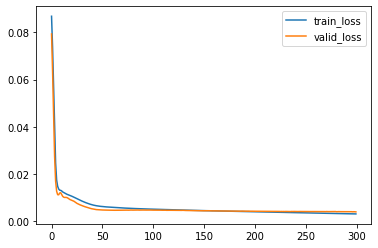

In [10]:
from autorch.utils import PartBulider
c620 = PartBulider(c620_df,x_col,y_col,normalize_idx_list=n_idx,limit_y_range=True)
c620.train()

In [11]:
c620.test(e=2e-2)

,R2,MSE,MAPE
Tatoray Stripper C620 Split Factors Calculation_Split Factor for Individual Component to Tatoray Stripper C620 Vent Gas_Hydrogen_Fraction,0,3.61597e-06,0.176662
Tatoray Stripper C620 Split Factors Calculation_Split Factor for Individual Component to Tatoray Stripper C620 Vent Gas_Methane_Fraction,0,0.016841,12.5702
Tatoray Stripper C620 Split Factors Calculation_Split Factor for Individual Component to Tatoray Stripper C620 Vent Gas_Ethane_Fraction,0,0.178818,42.0343
Tatoray Stripper C620 Split Factors Calculation_Split Factor for Individual Component to Tatoray Stripper C620 Vent Gas_Propane_Fraction,0,0.254036,50.4019
Tatoray Stripper C620 Split Factors Calculation_Split Factor for Individual Component to Tatoray Stripper C620 Vent Gas_n-Butane_Fraction,0,0.258665,50.8588
...,...,...,...
Density_Bottoms Production Rate and Composition,0.407698,3.15622e-07,0.0604328
Tatoray Stripper C620 Operation_Yield Summary_Reflux Rate_m3/hr,0.507521,9.62573,2.38988
Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 14 (Control)_oC,0.217026,3.18514,0.917878
Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 34 (Control)_oC,0,0.439793,0.298186


In [12]:
from autorch.function import sp2wt
c620_sp,c620_op = c620.predict(c620.data['X_test']).iloc[:,:41*4],c620.predict(c620.data['X_test']).iloc[:,41*4:]
c620_feed = c620.data['X_test'][c['x41']].values
s1,s2,s3,s4 = c620_sp.iloc[:,:41].values,c620_sp.iloc[:,41:41*2].values,c620_sp.iloc[:,41*2:41*3].values,c620_sp.iloc[:,41*3:41*4].values
w1,w2,w3,w4 = sp2wt(c620_feed,s1),sp2wt(c620_feed,s2),sp2wt(c620_feed,s3),sp2wt(c620_feed,s4)
wt = np.hstack((w1,w2,w3,w4))
c620_wt = pd.DataFrame(wt,index=c620.data['X_test'].index,columns=c['vent_gas_x']+c['distillate_x']+c['sidedraw_x']+c['bottoms_x'])
c620_wt_real = c620_df.loc[c620_wt.index,c620_wt.columns]
c620_op_real = c620_df.loc[c620_op.index,c620_op.columns]
res = pd.DataFrame(index=c620_wt.columns,columns=['MAPE'])
for i in c620_wt.columns:
  res.loc[i] = c620.mape(c620_wt_real[i],c620_wt[i],e=0.02)
  res.loc['AVG'] = res.mean(axis=0)
res

,MAPE
Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Hydrogen_wt%,100
Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Methane_wt%,80.9063
Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Ethane_wt%,76.0755
Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Propane_wt%,82.2386
Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Butane_wt%,79.3266
...,...
Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_n-Pentylbenzene_wt%,56.2794
Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_n-Hexylbenzene_wt%,56.2927
Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_Nitrogen_wt%,NaN
Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_Oxygen_wt%,NaN


In [13]:
for i in c620_op.columns:
  res.loc[i] = c620.mape(c620_op_real[i],c620_op[i],e=0.02)
  res.loc['AVG'] = res.mean(axis=0)
res

,MAPE
Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Hydrogen_wt%,100
Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Methane_wt%,80.9063
Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Ethane_wt%,76.0755
Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Propane_wt%,82.2386
Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Butane_wt%,79.3266
...,...
Density_Sidedraw Production Rate and Composition,0.0476177
Density_Bottoms Production Rate and Composition,0.0604335
Tatoray Stripper C620 Operation_Yield Summary_Reflux Rate_m3/hr,2.38988
Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 14 (Control)_oC,0.917878


# 2.使用預訓練模型

2.1 用模擬數據先預訓練一個模型

  2%|▏         | 1/50 [00:00<00:35,  1.38it/s]

epoch:0 train_loss:0.0116 valid_loss:0.0022


100%|██████████| 50/50 [00:48<00:00,  1.03it/s]


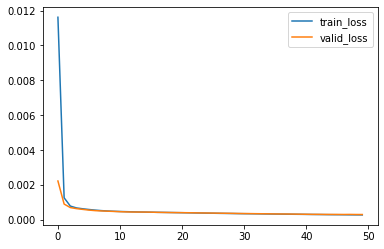

In [14]:
c620_df = pd.read_csv('/content/drive/MyDrive/台塑輕油案子/data/c620/cleaned/c620_train.csv',index_col=0).dropna(axis=0)
c620 = PartBulider(c620_df,x_col,y_col,normalize_idx_list=n_idx,limit_y_range=True,max_epochs=50)
c620.train()

In [15]:
c620.test(e=2e-2)

,R2,MSE,MAPE
Tatoray Stripper C620 Split Factors Calculation_Split Factor for Individual Component to Tatoray Stripper C620 Vent Gas_Hydrogen_Fraction,0,8.30364e-07,0.0556643
Tatoray Stripper C620 Split Factors Calculation_Split Factor for Individual Component to Tatoray Stripper C620 Vent Gas_Methane_Fraction,0.988322,2.18514e-07,0.0352306
Tatoray Stripper C620 Split Factors Calculation_Split Factor for Individual Component to Tatoray Stripper C620 Vent Gas_Ethane_Fraction,0.99423,2.68724e-06,0.12627
Tatoray Stripper C620 Split Factors Calculation_Split Factor for Individual Component to Tatoray Stripper C620 Vent Gas_Propane_Fraction,0.996829,1.07836e-05,0.301573
Tatoray Stripper C620 Split Factors Calculation_Split Factor for Individual Component to Tatoray Stripper C620 Vent Gas_n-Butane_Fraction,0.996413,5.56268e-05,0.761218
...,...,...,...
Density_Bottoms Production Rate and Composition,0.999536,7.56071e-12,0.000234614
Tatoray Stripper C620 Operation_Yield Summary_Reflux Rate_m3/hr,0.9978,0.301515,0.301117
Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 14 (Control)_oC,0.998572,0.0018017,0.0188229
Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 34 (Control)_oC,0.998552,0.00116054,0.0137282


2.2 把預訓練好的模型抽出來

In [16]:
import copy
from copy import deepcopy
pretrain_net = deepcopy(c620.net)
pretrain_net

Sequential(
  (0): Linear(in_features=44, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=172, bias=True)
  (5): Sigmoid()
)

2.3 在預訓練模型上丟進真實資料繼續訓練

  6%|▌         | 17/300 [00:00<00:03, 80.16it/s]

epoch:0 train_loss:0.0499 valid_loss:0.0515


 20%|█▉        | 59/300 [00:00<00:03, 80.12it/s]

epoch:50 train_loss:0.0053 valid_loss:0.0094


 38%|███▊      | 113/300 [00:01<00:02, 84.07it/s]

epoch:100 train_loss:0.0041 valid_loss:0.0076


 56%|█████▌    | 167/300 [00:02<00:01, 85.77it/s]

epoch:150 train_loss:0.0034 valid_loss:0.0066


 71%|███████   | 212/300 [00:02<00:01, 81.73it/s]

epoch:200 train_loss:0.0028 valid_loss:0.0059


 86%|████████▋ | 259/300 [00:03<00:00, 67.18it/s]

epoch:250 train_loss:0.0023 valid_loss:0.0060


100%|██████████| 300/300 [00:03<00:00, 76.89it/s]


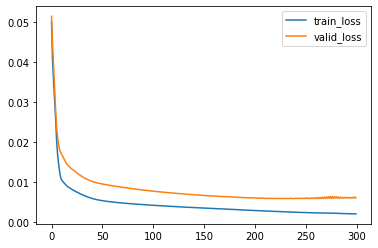

In [17]:
from torch.optim import Adam
c620_df = pd.read_excel('/content/drive/MyDrive/台塑輕油案子/data/c620/明志_遷移式學習_訓練資料_寄送版/c620_data.xlsx',index_col=0)
c620 = PartBulider(c620_df,x_col,y_col,normalize_idx_list=n_idx,limit_y_range=True)
c620.net = pretrain_net
c620.optimizer = Adam(c620.net.parameters(),lr=0.001)
c620.train()

In [18]:
c620.test(e=2e-2)

,R2,MSE,MAPE
Tatoray Stripper C620 Split Factors Calculation_Split Factor for Individual Component to Tatoray Stripper C620 Vent Gas_Hydrogen_Fraction,0,2.06329e-12,8.23947e-05
Tatoray Stripper C620 Split Factors Calculation_Split Factor for Individual Component to Tatoray Stripper C620 Vent Gas_Methane_Fraction,0,0.0176815,12.6436
Tatoray Stripper C620 Split Factors Calculation_Split Factor for Individual Component to Tatoray Stripper C620 Vent Gas_Ethane_Fraction,0,0.172765,41.255
Tatoray Stripper C620 Split Factors Calculation_Split Factor for Individual Component to Tatoray Stripper C620 Vent Gas_Propane_Fraction,0,0.253618,50.3605
Tatoray Stripper C620 Split Factors Calculation_Split Factor for Individual Component to Tatoray Stripper C620 Vent Gas_n-Butane_Fraction,0,0.257985,50.792
...,...,...,...
Density_Bottoms Production Rate and Composition,0.766062,2.16942e-07,0.0463909
Tatoray Stripper C620 Operation_Yield Summary_Reflux Rate_m3/hr,0.161992,19.2498,2.65847
Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 14 (Control)_oC,0.642516,6.31619,1.13257
Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 34 (Control)_oC,0.492137,0.755549,0.385144


In [19]:
from autorch.function import sp2wt
c620_sp,c620_op = c620.predict(c620.data['X_test']).iloc[:,:41*4],c620.predict(c620.data['X_test']).iloc[:,41*4:]
c620_feed = c620.data['X_test'][c['x41']].values
s1,s2,s3,s4 = c620_sp.iloc[:,:41].values,c620_sp.iloc[:,41:41*2].values,c620_sp.iloc[:,41*2:41*3].values,c620_sp.iloc[:,41*3:41*4].values
w1,w2,w3,w4 = sp2wt(c620_feed,s1),sp2wt(c620_feed,s2),sp2wt(c620_feed,s3),sp2wt(c620_feed,s4)
wt = np.hstack((w1,w2,w3,w4))
c620_wt = pd.DataFrame(wt,index=c620.data['X_test'].index,columns=c['vent_gas_x']+c['distillate_x']+c['sidedraw_x']+c['bottoms_x'])
c620_wt_real = c620_df.loc[c620_wt.index,c620_wt.columns]
c620_op_real = c620_df.loc[c620_op.index,c620_op.columns]
res = pd.DataFrame(index=c620_wt.columns,columns=['MAPE'])
for i in c620_wt.columns:
  res.loc[i] = c620.mape(c620_wt_real[i],c620_wt[i],e=0.02)
  res.loc['AVG'] = res.mean(axis=0)
res

,MAPE
Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Hydrogen_wt%,100
Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Methane_wt%,76.903
Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Ethane_wt%,68.1716
Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Propane_wt%,73.8207
Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Butane_wt%,70.655
...,...
Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_n-Pentylbenzene_wt%,49.9062
Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_n-Hexylbenzene_wt%,49.912
Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_Nitrogen_wt%,NaN
Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_Oxygen_wt%,NaN


In [20]:
for i in c620_op.columns:
  res.loc[i] = c620.mape(c620_op_real[i],c620_op[i],e=0.02)
  res.loc['AVG'] = res.mean(axis=0)
res

,MAPE
Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Hydrogen_wt%,100
Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Methane_wt%,76.903
Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Ethane_wt%,68.1716
Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Propane_wt%,73.8207
Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Butane_wt%,70.655
...,...
Density_Sidedraw Production Rate and Composition,0.119001
Density_Bottoms Production Rate and Composition,0.0463913
Tatoray Stripper C620 Operation_Yield Summary_Reflux Rate_m3/hr,2.65847
Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 14 (Control)_oC,1.13257


In [21]:
c620.shrink()

In [22]:
joblib.dump(c620,'/content/drive/MyDrive/台塑輕油案子/data/c620/model/c620_real_data.pkl')

['/content/drive/MyDrive/台塑輕油案子/data/c620/model/c620_real_data.pkl']